In [77]:
import warnings

from tqdm import tqdm
from IPython.display import clear_output

import pandas as pd
import numpy as np

from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import BayesSearchCV


%matplotlib inline
np.random.seed(42)
warnings.filterwarnings('ignore')

In [2]:
classes_df = pd.read_csv("classes_train.csv")
features_df = pd.read_csv("features_train.csv")

In [3]:
classes_df.shape

(2400, 1)

In [4]:
classes_df.head()

,is_bot
0,0
1,0
2,0
3,0
4,0


In [5]:
features_df.shape

(2400, 20)

In [6]:
features_df.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,5124,6641,3074,13768,126,0,0,1,2711,1.890077,2.449650,1.133899,5.078569,0.046477,2.160377,12,0,14,0,73
1,10672,8465,1575,4561,191,0,1,1,4424,2.412297,1.913427,0.356013,1.030967,0.043174,5.374603,11,0,23,0,142
2,704,3108,454,2400,77,0,0,0,1358,0.518409,2.288660,0.334315,1.767305,0.056701,6.845815,12,0,18,0,90
3,6091,304528,526,599,1515,0,1,1,4214,1.445420,72.265781,0.124822,0.142145,0.359516,578.950570,10,0,11,0,51
4,12967,13693,204,1177,452,0,1,1,3200,4.052187,4.279063,0.063750,0.367812,0.141250,67.122549,13,0,14,0,106


In [7]:
data = features_df.copy()
data["is_bot"] = classes_df.is_bot

In [8]:
data = data.sample(frac=1).reset_index(drop=True)

In [9]:
data.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,...,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length,is_bot
0,2370,51,0,0,2,1,1,0,1276,1.857367,...,0.000000,0.000000,0.001567,23524.000000,15,0,18,0,140,1
1,2915,669,427,5,10,1,1,0,2645,1.102079,...,0.161437,0.001890,0.003781,1.566745,11,1,11,1,50,1
2,25554,2155,2074,9800,128,0,1,1,4429,5.769700,...,0.468277,2.212689,0.028900,1.039055,8,0,10,0,113,0
3,192186,11189,2606,5632,611,1,1,1,5181,37.094383,...,0.502992,1.087049,0.117931,4.293553,11,0,11,0,154,0
4,484,33,1,44,1,0,0,0,830,0.583133,...,0.001205,0.053012,0.001205,33.000000,11,0,19,0,138,1


In [10]:
data.shape

(2400, 21)

In [11]:
data.nunique()

statuses_count                     2341
followers_count                    2079
friends_count                      1493
favourites_count                   1767
listed_count                        922
is_default_profile                    2
is_profile_use_background_image       2
is_verified                           2
user_age                           1617
tweets_freq                        2399
followers_growth_rate              2400
friends_growth_rate                2208
favourites_growth_rate             2096
listed_growth_rate                 2354
followers_friends_ratio            2145
screen_name_length                   13
num_digits_in_screen_name             6
length_of_name                       42
num_digits_in_name                    6
description_length                  164
is_bot                                2
dtype: int64

In [12]:
data.isnull().sum()

statuses_count                     0
followers_count                    0
friends_count                      0
favourites_count                   0
listed_count                       0
is_default_profile                 0
is_profile_use_background_image    0
is_verified                        0
user_age                           0
tweets_freq                        0
followers_growth_rate              0
friends_growth_rate                0
favourites_growth_rate             0
listed_growth_rate                 0
followers_friends_ratio            0
screen_name_length                 0
num_digits_in_screen_name          0
length_of_name                     0
num_digits_in_name                 0
description_length                 0
is_bot                             0
dtype: int64

In [13]:
X = data.drop(columns=["is_bot"], axis=1)
y = data.is_bot

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

1. Базовый контест
1.1. Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [15]:
d_tree_bcv = BayesSearchCV(estimator=DecisionTreeClassifier(), search_spaces={
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [depth for depth in range(2, 21, 1)]
}, scoring="f1_weighted")

In [16]:
%%time
d_tree_bcv.fit(X_train, y_train)

CPU times: total: 48.4 s
Wall time: 53.8 s


BayesSearchCV(estimator=DecisionTreeClassifier(), scoring='f1_weighted',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                           13, 14, 15, 16, 17, 18, 19, 20],
                             'splitter': ['best', 'random']})

In [17]:
d_tree_model = d_tree_bcv.best_estimator_
d_tree_model

DecisionTreeClassifier(criterion='entropy', max_depth=16)

In [18]:
f1_score(y_test, d_tree_model.predict(X_test), average="weighted")

0.9924878085006312

In [19]:
cross_val_scores = cross_val_score(d_tree_model, X_test, y_test, scoring="f1_weighted")
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9924835794926906 0.006696119358433926


In [20]:
knn_bcv = BayesSearchCV(estimator=KNeighborsClassifier(), search_spaces={
    "n_neighbors": [n for n in range(1, 100)],
}, scoring="f1_weighted")

In [21]:
%%time
knn_bcv.fit(X_train, y_train)

CPU times: total: 27.9 s
Wall time: 26.1 s


BayesSearchCV(estimator=KNeighborsClassifier(), scoring='f1_weighted',
              search_spaces={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19, 20,
                                             21, 22, 23, 24, 25, 26, 27, 28, 29,
                                             30, ...]})

In [22]:
knn_model = knn_bcv.best_estimator_
knn_model

KNeighborsClassifier(n_neighbors=3)

In [23]:
f1_score(y_test, knn_model.predict(X_test), average="weighted")

0.9663277291184268

In [24]:
cross_val_scores = cross_val_score(knn_model, X_test, y_test, scoring="f1_weighted")
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9682771635984405 0.009692100500483688


In [25]:
linear_svc_bcv = BayesSearchCV(estimator=LinearSVC(), search_spaces={
    "C": [c / 10 for c in range(1, 100)],
}, scoring="f1_weighted")

In [26]:
%%time
linear_svc_bcv.fit(X_train, y_train)

CPU times: total: 25.5 s
Wall time: 25.5 s


BayesSearchCV(estimator=LinearSVC(), scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                   1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
                                   2.8, 2.9, 3.0, ...]})

In [27]:
linear_svc_model = linear_svc_bcv.best_estimator_
linear_svc_model

LinearSVC(C=1.7)

In [28]:
f1_score(y_test, linear_svc_model.predict(X_test), average="weighted")

0.9731247703220871

In [29]:
cross_val_scores = cross_val_score(linear_svc_model, X_test, y_test, scoring="f1_weighted")
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9441210473089878 0.03405898532329408


In [30]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [31]:
f1_score(y_test, naive_bayes.predict(X_test), average="weighted")

0.8765236363636365

In [32]:
cross_val_scores = cross_val_score(naive_bayes, X_test, y_test, scoring="f1_weighted")
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9045741383042879 0.01397811985766961


In [33]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [34]:
f1_score(y_test, log_reg.predict(X_test), average="weighted")

0.9574424342105264

In [35]:
cross_val_scores = cross_val_score(log_reg, X_test, y_test, scoring="f1_weighted")
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9613260997979486 0.00480580384275249


In [36]:
catboost_model = CatBoostClassifier(eval_metric="TotalF1")
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), use_best_model=True)
clear_output()

In [37]:
f1_score(y_test, catboost_model.predict(X_test), average="weighted")

0.9908283939221227

In [38]:
cross_val_scores = cross_val_score(catboost_model, X_test, y_test, scoring="f1_weighted")
clear_output()
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9949898548192226 0.004886289549408798


In [39]:
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
clear_output()

In [40]:
dump(catboost_model, filename="model.joblib")

['model.joblib']

2. Вторичные контесты

2.1. Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества.

Рассмотрим корреляцию между признаками

<AxesSubplot:>

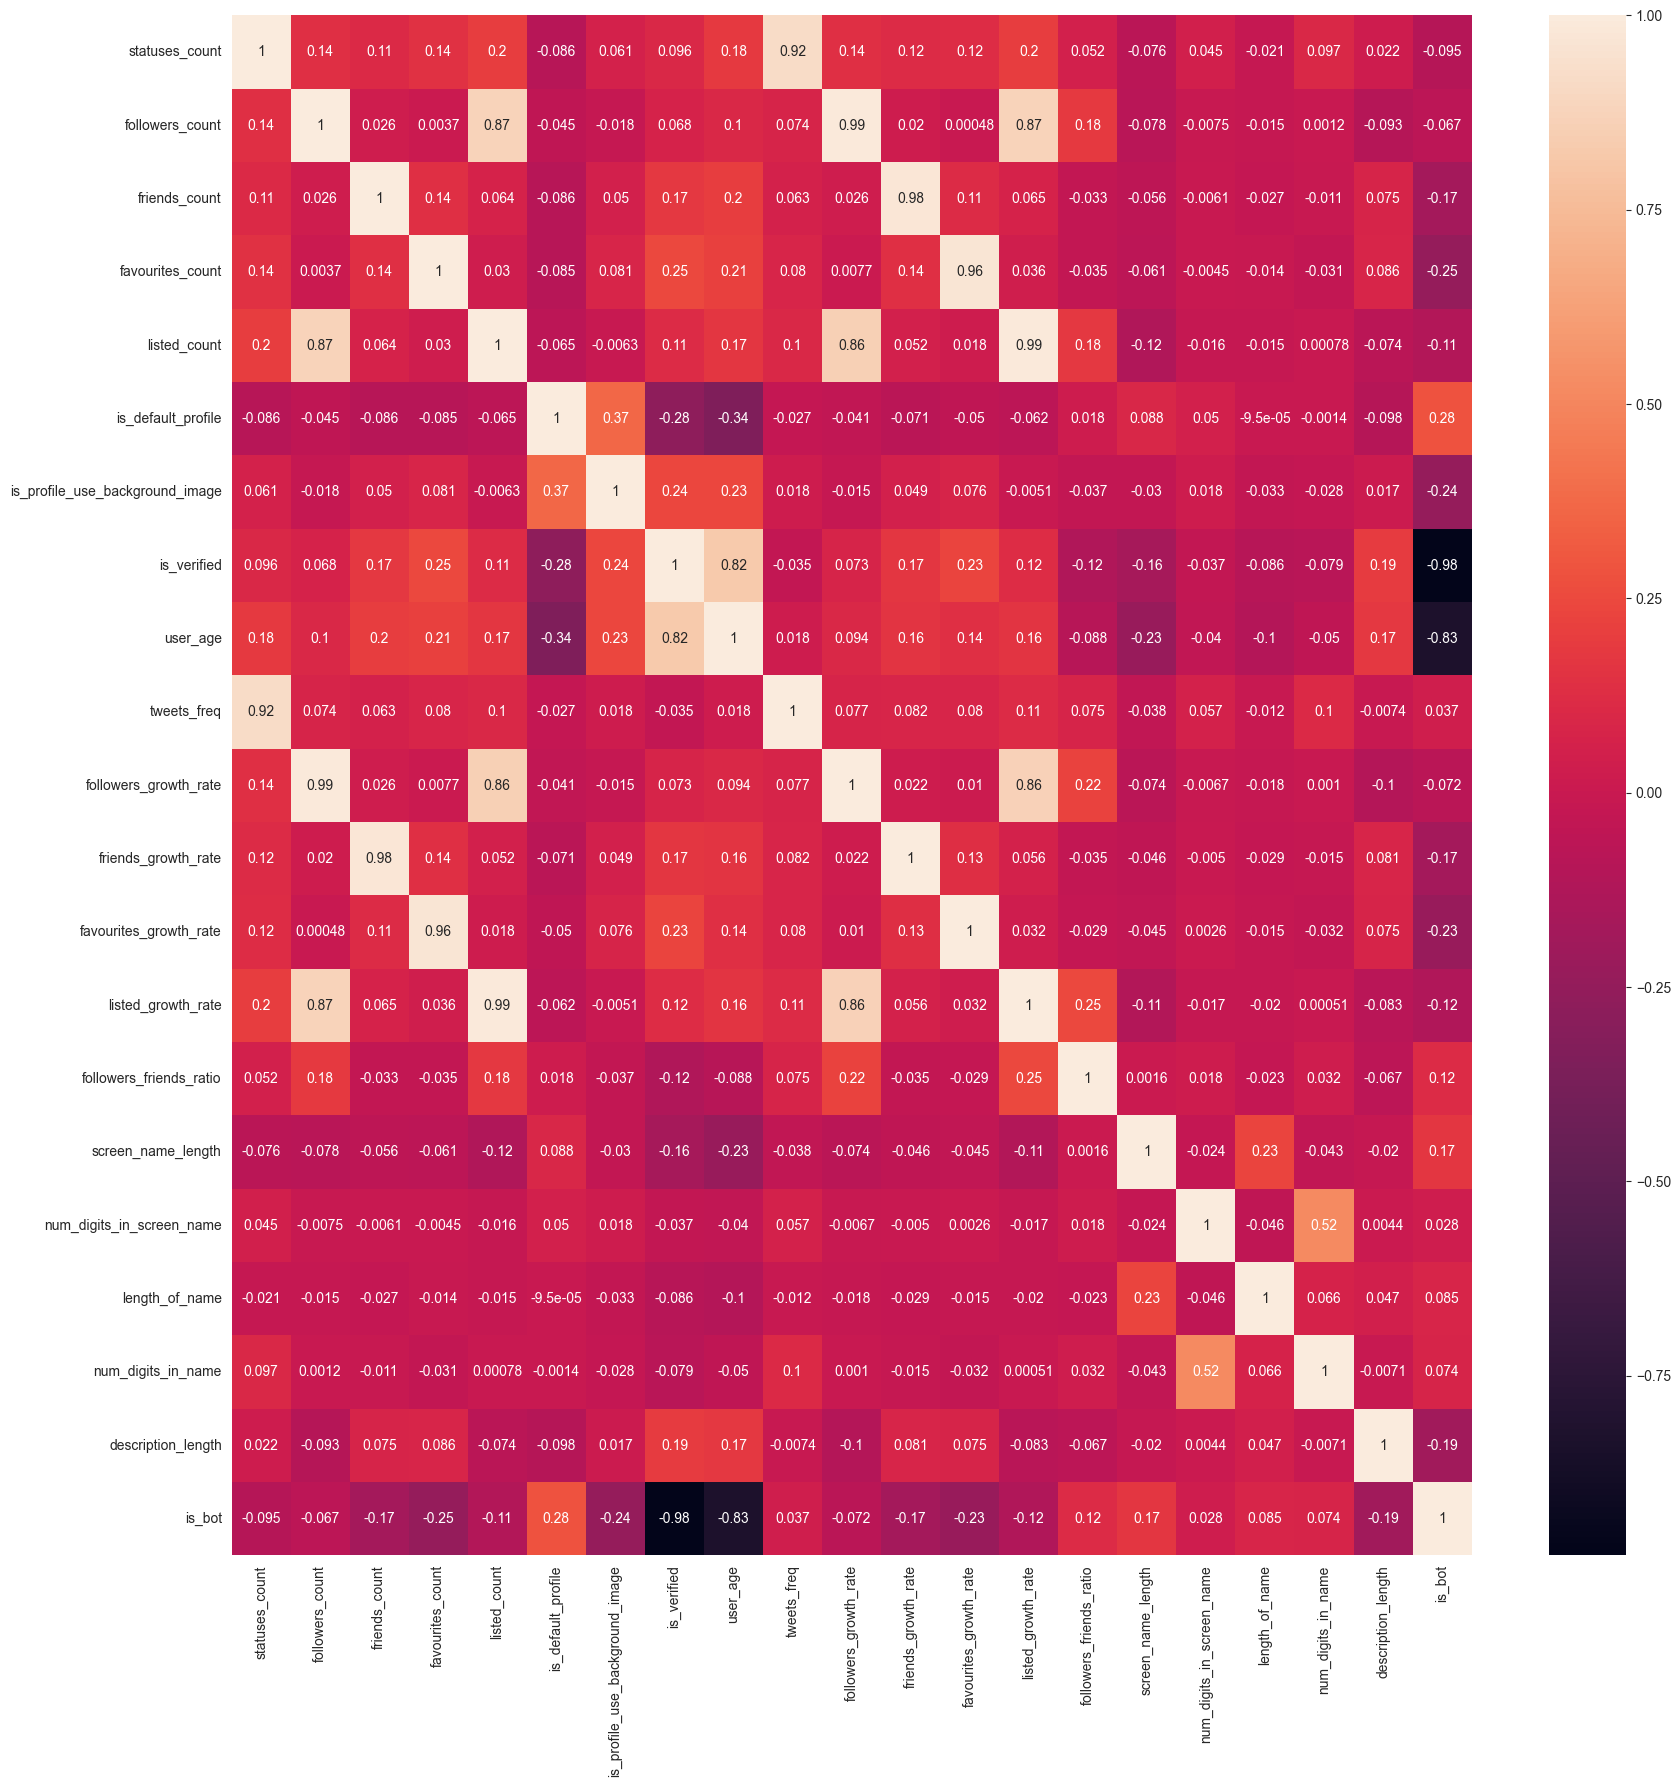

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=data.corr(), annot=True, ax=ax)

Из матрицы корреляции видно следующее:

* Сильно коррелируют с меткой __is_bot__:
    * __is_verified__
    * __user_age__
* Слабо коррелируют с меткой __is_bot__:
    * __statuses_count__
    * __followers_count__
    * __tweets_freq__
    * __followers_growth_rate__
    * __num_digits_in_screen_name__
    * __length_of_name__
    * __num_digits_in_name__
* Признаки, которые сильно коррелируют друг с другом (<признак>: <коррелирующие с ним>):
    * __statuses_count__: tweets_freq
    * __followers_count__: listed_growth_rate, followers_growth_rate, listed_count
    * __friends_count__: friends_growth_rate
    * __favourites_count__: favourites_growth_rate
    * __listed_count__: listed_growth_rate, followers_growth_rate
    * __is_verified__: __user_age__
    * __followers_growth_rate__: listed_growth_rate

In [42]:
# удалим из набора данных слабо коррелирующие признаки с меткой
new_data = data.drop(columns=[
    "statuses_count",
    "followers_count",
    "tweets_freq",
    "followers_growth_rate",
    "num_digits_in_screen_name",
    "length_of_name",
    "num_digits_in_name",
], axis=1)

In [43]:
# удалим из набора данных сильно коррелирующие между собой признаки
new_data = new_data.drop(columns=[
    "friends_growth_rate",
    "favourites_growth_rate",
    "listed_growth_rate",
], axis=1)

In [44]:
new_data.shape

(2400, 11)

In [45]:
new_X, new_y = new_data.drop(columns=["is_bot"], axis=1), new_data.is_bot

In [46]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.5)

In [47]:
new_catboost_model = CatBoostClassifier(eval_metric="TotalF1")

In [48]:
new_x_train_, new_x_val_, new_y_train_, new_y_val_ = train_test_split(new_X_train, new_y_train, test_size=0.2)
new_catboost_model.fit(new_x_train_, new_y_train_, eval_set=(new_x_val_, new_y_val_), use_best_model=True)
clear_output()

In [49]:
f1_score(new_y_test, new_catboost_model.predict(new_X_test), average="weighted")

0.9933488222396556

In [50]:
cross_val_scores = cross_val_score(new_catboost_model, new_X_test, new_y_test, scoring="f1_weighted")
clear_output()
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9966853098241799 0.0048197379390936415


Попытаемся сократить размерность данных при помощи метода главных компонент (PCA)

In [51]:
PCA_N_COMPONENTS = 10

In [52]:
pca = PCA(n_components=PCA_N_COMPONENTS)

In [53]:
pca.fit(X)

PCA(n_components=10)

In [54]:
pca_X = pca.transform(X)

In [55]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X, new_y, test_size=0.5)

In [56]:
pca_catboost_model = CatBoostClassifier(eval_metric="TotalF1")

In [57]:
pca_x_train_, pca_x_val_, pca_y_train_, pca_y_val_ = train_test_split(pca_X_train, pca_y_train, test_size=0.2)
pca_catboost_model.fit(pca_x_train_, pca_y_train_, eval_set=(pca_x_val_, pca_y_val_), use_best_model=True)
clear_output()

In [58]:
f1_score(pca_y_test, pca_catboost_model.predict(pca_X_test), average="weighted")

0.9908281117443427

In [59]:
cross_val_scores = cross_val_score(pca_catboost_model, pca_X_test, pca_y_test, scoring="f1_weighted")
clear_output()
print(np.mean(cross_val_scores), np.std(cross_val_scores))

0.9891301264391746 0.0050164431705706485


2.2. Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения.

In [60]:
catboost_model = CatBoostClassifier(eval_metric="TotalF1")
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), use_best_model=True)
clear_output()

In [61]:
print(classification_report(y_test, catboost_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       894
           1       0.98      1.00      0.99       306

    accuracy                           0.99      1200
   macro avg       0.99      1.00      0.99      1200
weighted avg       0.99      0.99      0.99      1200



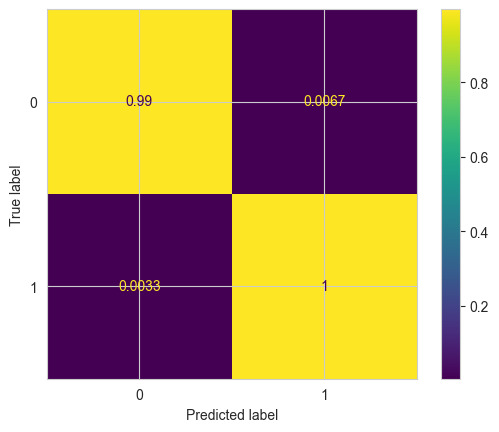

In [62]:
plot_confusion_matrix(catboost_model, X_test, y_test, normalize="true")

3. Углубленное аналитическое исследование по имеющимся данным

3.1. Тем или иным способом выполнить сравнительное исследование значимости различных признаков применительно к произвольному фиксированному классификатору.

In [64]:
catboost_model = CatBoostClassifier(eval_metric="TotalF1")
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), use_best_model=True)
clear_output()

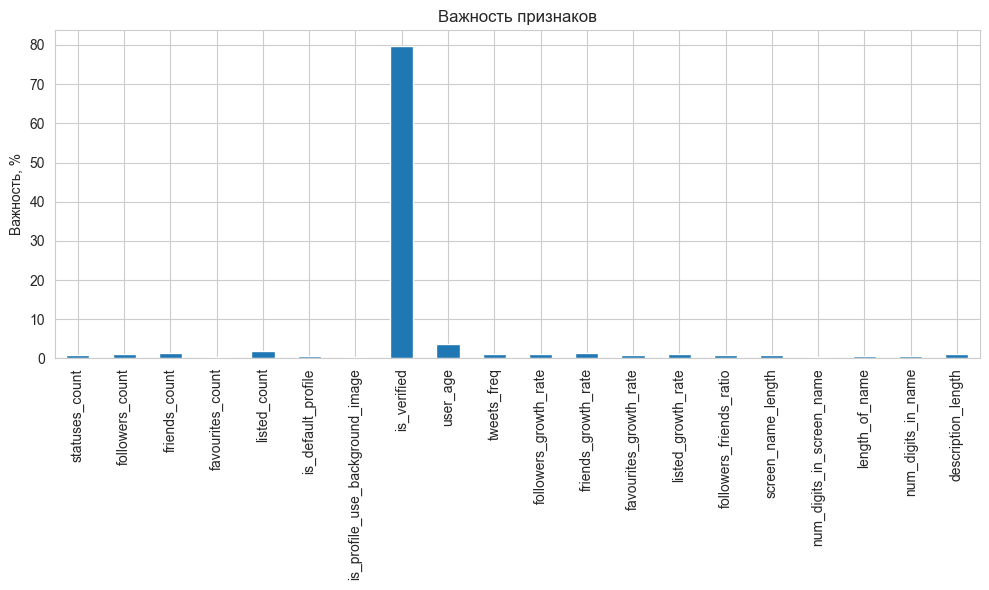

In [66]:
cat_iris_imp = pd.Series(catboost_model.get_feature_importance(), data.drop(["is_bot"], axis=1).columns)
fig, ax = plt.subplots(figsize=(10,6))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

3.2. Синтезировать 3 или более собственных признаков на основе имеющихся и показать, что они имеют какие-либо преимущества перед хотя бы какими либо из базовых признаков.

In [63]:
#TODO

3.3. Выбрать один базовый тип ML-модели на свой вкус (SVM, дерево решений, случайный лес, градиентный бустинг и пр.) и провести ROC-анализ в зависимости от её гиперпараметров.

Рассмотрим дерево решений.

Основными гиперпараметрами данной модели являются:

* Максимальная глубина дерева (*max_depth*)
* Критерий разделения данных (*criterion*): выделяют коэффициент Джини (*gini*), энтропию (*entropy*)

При проведении ROC-анализа будем пользоваться ROC-AUC - площадь под графиком ROC-кривой

Рассмотрим точность модели в зависимости от глубины дерева

In [91]:
depths = [depth for depth in range(2, 50)]
depth_roc_auc = []

for depth in tqdm(depths):
    d_tree_ = DecisionTreeClassifier(max_depth=depth)
    depth_roc_auc.append(np.mean(cross_val_score(d_tree_, X, y, scoring="roc_auc")))

100%|██████████| 48/48 [00:01<00:00, 25.96it/s]


<AxesSubplot:xlabel='depth', ylabel='roc_auc'>

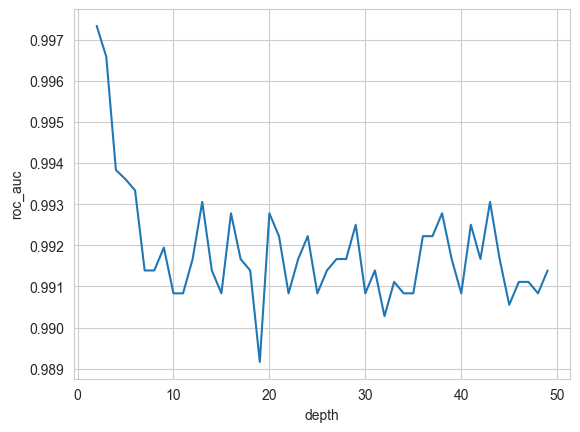

In [92]:
depth_roc_auc_df = pd.DataFrame(data={"depth": depths, "roc_auc": depth_roc_auc})
sns.lineplot(data=depth_roc_auc_df, x="depth", y="roc_auc")

In [93]:
depth_roc_auc_df.sort_values(by=['roc_auc'], ascending=False)

,depth,roc_auc
0,2,0.997331
1,3,0.996581
2,4,0.993831
3,5,0.993606
4,6,0.993333
11,13,0.993056
41,43,0.993056
18,20,0.992778
14,16,0.992778
36,38,0.992778


Из данной зависимости можно сделать вывод:

Чем глубже дерево, тем меньше значение ROC-AUC. Это связано с тем, что дерево с большей глубиной уходит в частные случаи разделения данных.

Рассмотрим зависимость от критерия разделения данных

In [106]:
criterions = ["gini", "entropy"]
criterions_roc_auc = []

for criterion in tqdm(criterions):
    d_tree_ = DecisionTreeClassifier(criterion=criterion)
    criterions_roc_auc.append(np.mean(cross_val_score(d_tree_, X, y, scoring="roc_auc")))

100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


<AxesSubplot:xlabel='criterion', ylabel='roc_auc'>

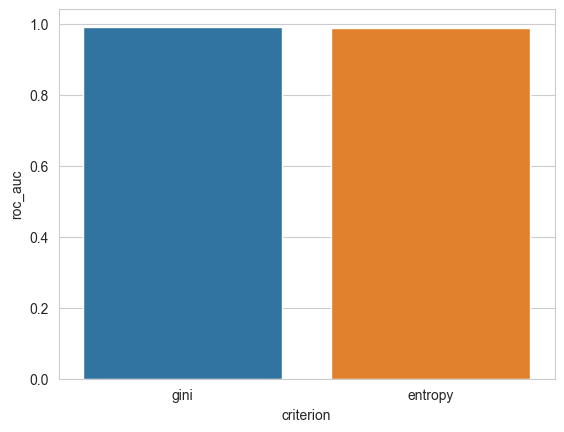

In [107]:
criterions_roc_auc_df = pd.DataFrame(data={"criterion": criterions, "roc_auc": criterions_roc_auc})
sns.barplot(data=criterions_roc_auc_df, x="criterion", y="roc_auc")

In [108]:
criterions_roc_auc_df

,criterion,roc_auc
0,gini,0.992500
1,entropy,0.988056


Из данных результатов можно сделать вывод, что для данного набора данных лучшим критерием с небольшим перевесом является статистический коэффициент Джини

3.4. Провести исследование влияние параметров обучения на недо- и переобученность модели.

Также рассмотрим пример дерева решений

Единственный параметр, который влияет на обученность и недообученность модели является его глубина, которую можно регулировать при помощи параметра __max_depth__

In [113]:
train_d_tree_info = []
depths = [depth for depth in range(2, 50)]

for depth in tqdm(depths):
    d_tree_ = DecisionTreeClassifier(max_depth=depth)
    d_tree_.fit(X_train, y_train)

    train_roc_auc = roc_auc_score(y_train, d_tree_.predict(X_train))

    train_d_tree_info.append({"depth": depth, "roc_auc": train_roc_auc, "type": "train"})

    test_roc_auc = roc_auc_score(y_test, d_tree_.predict(X_test))

    train_d_tree_info.append({"depth": depth, "roc_auc": test_roc_auc, "type": "test"})

100%|██████████| 48/48 [00:00<00:00, 152.38it/s]


In [114]:
train_d_tree_info_df = pd.DataFrame(data=train_d_tree_info)

<AxesSubplot:xlabel='depth', ylabel='roc_auc'>

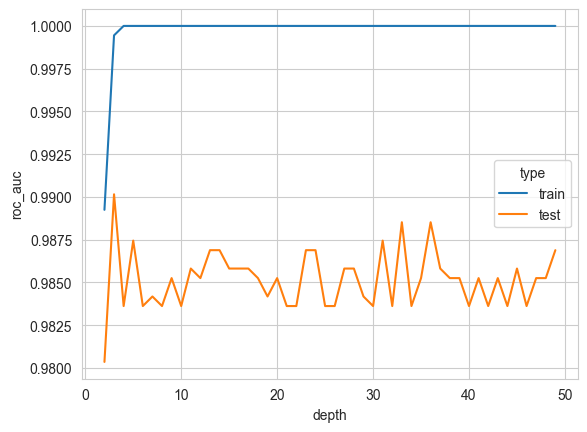

In [116]:
sns.lineplot(data=train_d_tree_info_df, x="depth", y="roc_auc", hue="type")

Как можно видеть, уже при глубине 4 на тренировочном наборе данных дерево решений для данного набора дает ROC-AUC равный 1, а точность на тестовом наборе сильно падает.

Из этого можно сделать вывод, что чем больше глубина дерева, тем сильнее идет переобучение

Однако при глубине дерева 2, модель еще недообучена, так как при глубине 3 модель показывает лучшую точность